In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import seaborn as sns
import math
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 16})

#from jupyterthemes import jtplot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid = False)

random_state = 42

In [2]:
listings = pd.read_csv('./listings.csv')
zipcodes = pd.Series(listings['zipcode'].unique()).dropna()
demographics = pd.read_csv('./demographics.csv')

In [3]:
listings['overall_activity'] = np.array(listings['availability_30'])*np.array(listings['accommodates'])

In [4]:
multihost_ids = {}

for hostid in listings['host_id']:
    if hostid in multihost_ids.keys():
        multihost_ids[hostid] += 1
    else:
        multihost_ids[hostid] = 1
            

In [5]:
multihost_ids

{2600734: 1,
 4295819: 4,
 36223353: 1,
 746673: 6,
 9385592: 3,
 27672030: 1,
 29622653: 1,
 14686944: 1,
 546222: 1,
 1320865: 1,
 19403133: 1,
 13467372: 1,
 9718884: 1,
 47803024: 1,
 8260778: 2,
 2363511: 2,
 7981022: 2,
 19133972: 2,
 940569: 6,
 1826173: 1,
 32045149: 1,
 3039083: 2,
 3441402: 1,
 58951814: 1,
 12054902: 1,
 5564999: 2,
 21260531: 1,
 27754937: 1,
 6773853: 1,
 2392127: 2,
 34112754: 1,
 6074062: 3,
 18085000: 1,
 9462156: 1,
 2661590: 1,
 2799158: 2,
 10240937: 1,
 4752708: 1,
 20475301: 1,
 10077483: 2,
 45476547: 1,
 18001156: 2,
 2939506: 1,
 48495453: 1,
 31220775: 1,
 32351091: 1,
 722034: 2,
 1482216: 2,
 8120727: 1,
 43818498: 1,
 335286: 2,
 53185861: 1,
 4670457: 1,
 3055097: 1,
 2824848: 1,
 42522378: 1,
 23163164: 1,
 17383261: 1,
 35475526: 1,
 6077075: 1,
 64434534: 2,
 6676667: 2,
 12052929: 1,
 4664726: 1,
 32065101: 1,
 43536753: 1,
 266195: 1,
 4846203: 1,
 17736312: 1,
 17973365: 1,
 6705868: 2,
 27076457: 1,
 8363482: 2,
 3311410: 1,
 4493147

In [6]:
listings['state'].unique()

array(['NC', 'TX', 'OR', 'TN', 'LA', 'CA', 'DC'], dtype=object)

In [7]:
listings['multi'] = listings['host_id'].apply(lambda z: 1 if multihost_ids[z] > 1 else 0)

In [8]:
listings = listings[listings['multi'] == 1]
listings

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,has_availability,...,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,state,weekly_price,zipcode,overall_activity,multi
1,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",17,1.0,Real Bed,1.0,2.0,strict,Asheville,NaN,...,10.0,9.0,96.0,9.0,Entire home/apt,NC,NaN,28806.0,68.0,1
3,6.0,"{Internet,""Wireless Internet"",""Air Conditionin...",28,2.5,Real Bed,1.0,6.0,moderate,Asheville,NaN,...,NaN,NaN,NaN,NaN,Shared room,NC,NaN,28806.0,168.0,1
4,6.0,"{Internet,""Wireless Internet"",""Free Parking on...",25,2.5,Real Bed,1.0,6.0,moderate,Asheville,NaN,...,9.0,9.0,93.0,10.0,Shared room,NC,NaN,28806.0,150.0,1
5,10.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",17,2.5,Real Bed,4.0,5.0,strict,Asheville,NaN,...,9.0,8.0,78.0,8.0,Entire home/apt,NC,"$1,550.00",28806.0,170.0,1
15,4.0,"{TV,Internet,""Wireless Internet"",""Air Conditio...",18,1.0,Real Bed,1.0,2.0,moderate,Asheville,NaN,...,10.0,9.0,93.0,9.0,Private room,NC,NaN,28806.0,72.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50306,10.0,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",16,2.0,Real Bed,3.0,4.0,strict,los angeles,NaN,...,9.0,10.0,70.0,8.0,Entire home/apt,CA,NaN,91364,160.0,1
50307,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5,1.0,Real Bed,1.0,3.0,strict,woodland hills,NaN,...,10.0,9.0,91.0,9.0,Entire home/apt,CA,NaN,91367,20.0,1
50309,2.0,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",0,1.0,Real Bed,1.0,1.0,flexible,los angeles,NaN,...,NaN,NaN,NaN,NaN,Private room,CA,NaN,91364,0.0,1
50312,4.0,"{TV,""Air conditioning"",Kitchen,""Free parking o...",13,0.5,Real Bed,1.0,2.0,strict,los angeles,NaN,...,NaN,NaN,NaN,NaN,Entire home/apt,CA,NaN,90744,52.0,1


In [9]:
listings['state'].unique()

array(['NC', 'TX', 'TN', 'LA', 'CA', 'DC'], dtype=object)

In [10]:
zipcodes = pd.Series(listings['zipcode'].unique()).dropna()

number_of_properties = []
overall_activity = []
overall_capacity = []
overall_availability = []
dzip = {}

for z in zipcodes:
    number_of_properties.append(len(listings[listings['zipcode'] == z]))
    overall_activity.append(sum(listings[listings['zipcode'] == z]['overall_activity']))
    overall_capacity.append(sum(listings[listings['zipcode'] == z]['accommodates']))
    overall_availability.append(sum(listings[listings['zipcode'] == z]['availability_30']))
    dzip[z] = listings[listings['zipcode'] == z]['state'].unique()[0]

In [11]:
dfzip = pd.DataFrame()
dfzip['zipcodes'] = zipcodes
dfzip['number_of_listings'] = number_of_properties
dfzip['overall_capacity'] = overall_capacity
dfzip['overall_availability'] = overall_availability
dfzip['overall_activity'] = overall_activity

# Part 1: Cleaning zipcodes data

In [12]:
def clean(zipcode):
    # str to int
    if zipcode != zipcode:
        return np.nan
    elif  len(zipcode.split('.')) > 1:
        return int(zipcode.split('.')[0])
    elif len(zipcode.split('-')) > 1:
        return int(zipcode.split('-')[0])
    elif len(zipcode.split(':')) > 1:
        return int(zipcode.split(':')[0])
    elif len(zipcode.split(' ')) > 1:
        if len(zipcode.split(' ')) == 2:
            return int(zipcode.split(' ')[1])
        else:
            return int(zipcode.split(' ')[0])
        
    elif len(zipcode.split('\n')) > 1:
        return int(zipcode.split('\n')[0])
    else:
        return int(zipcode)

In [13]:
clean_zipcodes = []
states_of_clean_zipcodes = []

for i in zipcodes:
    clean_zipcodes.append(clean(i))
    states_of_clean_zipcodes.append(dzip[i])

In [14]:
dfzip['zipcode'] = clean_zipcodes
dfzip['state'] = states_of_clean_zipcodes
dfzip

,zipcodes,number_of_listings,overall_capacity,overall_availability,overall_activity,zipcode,state
0,28806.0,76,256.0,1267,4070.0,28806,NC
1,28803.0,48,202.0,918,3711.0,28803,NC
2,28805.0,48,173.0,718,2445.0,28805,NC
3,28804.0,61,209.0,1118,3727.0,28804,NC
4,28801.0,84,277.0,1192,4468.0,28801,NC
...,...,...,...,...,...,...,...
373,91306,14,52.0,322,1076.0,91306,CA
374,90095,1,3.0,3,9.0,90095,CA
375,90601,10,27.0,84,194.0,90601,CA
376,90602,13,76.0,153,1233.0,90602,CA


In [15]:
dfzip['state'].value_counts()

CA    275
TX     43
TN     29
LA     22
NC      8
Name: state, dtype: int64

# Part 2: Combining demographic and Airbnb data for the postcodes, adding extra features

In [16]:
df_new = pd.merge(dfzip, demographics, on = 'zipcode')
df_new

,zipcodes,number_of_listings,overall_capacity,overall_availability,overall_activity,zipcode,state,population,5_years_or_less,5-9_years,...,"$9,999_or_less","$10,000-$14,999","$15,000-$24,999","$25,000-$34,999","$35,000-$49,999","$50,000-$64,999","$65,000-$74,999","$75,000_or_more",median_household_income,mean_household_income
0,28806.0,76,256.0,1267,4070.0,28806,NC,40326,2613,2687,...,7.7,9.1,13.2,11.9,20.3,18,9,10.8,41208,50635
1,28803.0,48,202.0,918,3711.0,28803,NC,31478,2083,1992,...,6.7,6.8,9.5,11.8,16.9,18.6,9.7,20.0,47474,72934
2,28805.0,48,173.0,718,2445.0,28805,NC,18010,808,1019,...,4.7,8.8,14.5,11.6,14.2,15.9,12.6,17.7,45335,63223
3,28804.0,61,209.0,1118,3727.0,28804,NC,21047,765,1095,...,5.7,5.6,10.6,11.2,16.7,16.2,9.7,24.3,50193,79470
4,28801.0,84,277.0,1192,4468.0,28801,NC,14300,689,457,...,12.2,12.9,15.1,13.9,12.6,13.1,5.9,14.3,31359,52163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,91306,14,52.0,322,1076.0,91306,CA,49532,3024,3230,...,4.4,5.1,8.2,10.9,12.4,17.6,14.9,26.5,61529,74726
365,90095,1,3.0,3,9.0,90095,CA,0,0,0,...,-,-,-,-,-,-,-,100.0,-,-
366,90601,10,27.0,84,194.0,90601,CA,34203,1973,1805,...,4.4,2.8,7.2,9.2,10.8,18.4,15.2,32.0,71366,89197
367,90602,13,76.0,153,1233.0,90602,CA,27421,2053,1768,...,5,5.7,13.5,11.4,15.8,17,11.2,20.4,48109,66575


In [17]:
df_new['$9,999_or_less']

0       7.7
1       6.7
2       4.7
3       5.7
4      12.2
       ... 
364     4.4
365       -
366     4.4
367       5
368     3.1
Name: $9,999_or_less, Length: 369, dtype: object

In [18]:
l1 = list(dfzip['zipcode'])
l2 = list(df_new['zipcode'])

list(set(l1) - set(l2))
# whatever

[90625, 91523, 70148, 91308, 90929, 78774, 91802, 701115]

In [19]:
for el in list(set(l1) - set(l2)):
    print(dfzip[dfzip['zipcode'] == el])



    zipcodes  number_of_listings  overall_capacity  overall_availability  \
309    90625                   1              10.0                    20   

     overall_activity  zipcode state  
309             200.0    90625    CA  
    zipcodes  number_of_listings  overall_capacity  overall_availability  \
179    91523                   1               4.0                    13   

     overall_activity  zipcode state  
179              52.0    91523    CA  
   zipcodes  number_of_listings  overall_capacity  overall_availability  \
99    70148                   1               8.0                    30   

    overall_activity  zipcode state  
99             240.0    70148    LA  
    zipcodes  number_of_listings  overall_capacity  overall_availability  \
370    91308                   1               4.0                    30   

     overall_activity  zipcode state  
370             120.0    91308    CA  
    zipcodes  number_of_listings  overall_capacity  overall_availability  \
363 

In [20]:
df_new['median_household_income'] = df_new['median_household_income'].apply(lambda el: np.nan if el == '-' else float(el))
df_new['mean_household_income'] = df_new['mean_household_income'].apply(lambda el: np.nan if el == '-' else float(el))

df_new['$9,999_or_less'] = df_new['$9,999_or_less'].apply(lambda el: np.nan if el == '-' else float(el))
df_new['$10,000-$14,999'] = df_new['$10,000-$14,999'].apply(lambda el: np.nan if el == '-' else float(el))

df_new['$15,000-$24,999'] = df_new['$15,000-$24,999'].apply(lambda el: np.nan if el == '-' else float(el))
df_new['$25,000-$34,999'] = df_new['$25,000-$34,999'].apply(lambda el: np.nan if el == '-' else float(el))
df_new['$35,000-$49,999'] = df_new['$35,000-$49,999'].apply(lambda el: np.nan if el == '-' else float(el))
df_new['$50,000-$64,999'] = df_new['$50,000-$64,999'].apply(lambda el: np.nan if el == '-' else float(el))
df_new['$65,000-$74,999'] = df_new['$65,000-$74,999'].apply(lambda el: np.nan if el == '-' else float(el))

df_new['5_years_or_less_fr'] = df_new['5_years_or_less']/df_new['population']
df_new['5-9_years_fr'] = df_new['5-9_years']/df_new['population']
df_new['10-14_years_fr'] = df_new['10-14_years']/df_new['population']
df_new['15-19_years_fr'] = df_new['15-19_years']/df_new['population']
df_new['20-24_years_fr'] = df_new['20-24_years']/df_new['population']
df_new['25-34_years_fr'] = df_new['25-34_years']/df_new['population']
df_new['35-44_years_fr'] = df_new['35-44_years']/df_new['population']
df_new['45-54_years_fr'] = df_new['45-54_years']/df_new['population']

df_new['55-59_years_fr'] = df_new['55-59_years']/df_new['population']
df_new['60-64_years_fr'] = df_new['60-64_years']/df_new['population']
df_new['65-74_years_fr'] = df_new['65-74_years']/df_new['population']
df_new['75-84_years_fr'] = df_new['75-84_years']/df_new['population']
df_new['85_years_or_more_fr'] = df_new['85_years_or_more']/df_new['population']

In [21]:
corr = df_new.corr()
corr

,number_of_listings,overall_capacity,overall_availability,overall_activity,zipcode,population,5_years_or_less,5-9_years,10-14_years,15-19_years,...,15-19_years_fr,20-24_years_fr,25-34_years_fr,35-44_years_fr,45-54_years_fr,55-59_years_fr,60-64_years_fr,65-74_years_fr,75-84_years_fr,85_years_or_more_fr
number_of_listings,1.000000,0.982979,0.986470,0.963971,-0.028663,-0.011337,-0.120484,-0.165696,-0.204233,-0.132773,...,-0.227573,0.135510,0.466451,0.191568,-0.142927,-0.090326,-0.046027,-0.061922,-0.097722,-0.038799
overall_capacity,0.982979,1.000000,0.969355,0.985493,-0.082109,-0.053529,-0.146233,-0.186772,-0.224686,-0.154965,...,-0.220743,0.123039,0.452742,0.159057,-0.137045,-0.062998,-0.016230,-0.048327,-0.093313,-0.042344
overall_availability,0.986470,0.969355,1.000000,0.976386,-0.019235,-0.007147,-0.119551,-0.160747,-0.196440,-0.136795,...,-0.240541,0.100936,0.433406,0.182422,-0.109047,-0.059433,-0.010148,-0.030672,-0.071338,-0.019082
overall_activity,0.963971,0.985493,0.976386,1.000000,-0.071710,-0.059031,-0.153308,-0.188992,-0.224202,-0.164610,...,-0.232853,0.086452,0.413950,0.146201,-0.099315,-0.026936,0.026124,-0.010955,-0.059980,-0.018583
zipcode,-0.028663,-0.082109,-0.019235,-0.071710,1.000000,0.216505,0.160867,0.169709,0.217763,0.214669,...,0.089211,-0.044463,-0.157996,0.094452,0.061001,-0.005710,-0.105794,-0.026550,0.073271,0.063937
population,-0.011337,-0.053529,-0.007147,-0.059031,0.216505,1.000000,0.930293,0.928620,0.927184,0.878203,...,0.316769,0.177926,-0.043626,-0.059607,-0.203733,-0.249701,-0.314175,-0.309569,-0.232729,-0.224610
5_years_or_less,-0.120484,-0.146233,-0.119551,-0.153308,0.160867,0.930293,1.000000,0.971220,0.941789,0.836978,...,0.291007,0.121840,-0.029581,-0.020749,-0.246588,-0.309486,-0.400022,-0.418184,-0.327878,-0.291269
5-9_years,-0.165696,-0.186772,-0.160747,-0.188992,0.169709,0.928620,0.971220,1.000000,0.971651,0.860114,...,0.338626,0.092547,-0.127776,-0.059404,-0.191642,-0.272426,-0.370347,-0.369874,-0.297965,-0.282265
10-14_years,-0.204233,-0.224686,-0.196440,-0.224202,0.217763,0.927184,0.941789,0.971651,1.000000,0.877154,...,0.375341,0.075673,-0.202473,-0.095429,-0.136174,-0.221193,-0.323019,-0.318434,-0.255798,-0.252175
15-19_years,-0.132773,-0.154965,-0.136795,-0.164610,0.214669,0.878203,0.836978,0.860114,0.877154,1.000000,...,0.673956,0.427532,-0.197917,-0.260177,-0.288918,-0.300840,-0.398891,-0.359441,-0.273479,-0.231610


# Part 3: Discussing the correlations

It is clear that the majority of Airbnb listings are in California (so not much point grouping by state), and trends are generally similar for each state. Quite remarkably, the demographic features that (anti)correlate most with Airbnb listings are population FRACTIONS of <5, 5-9, 10-14 and 15-19 yo, 25-34 yo etc BY AGE,  with income <15 k USD and income 50 - 75 k USD BY INCOME. Also, there is not much correlation with the number of households, meaning airbnb prices are driven mostly by other factors (e.g. venues). Almost no correlation with population, enhancing the point that airbnb is driven by venues (or might be). For the purpose of statistical test, we include median income. 

# Part 4: Investigating the patterns in proportion of young adult population (25-44), children population (0-14), low-income households (<15k) and medium-income households (50-75 k).

In [22]:
df2 = pd.DataFrame()

In [23]:
df2['zipcode'] = df_new['zipcode']
df2['state'] = df_new['state']
df2['number_of_listings'] = df_new['number_of_listings']
df2['overall_capacity'] = df_new['overall_capacity']
df2['overall_availability'] = df_new['overall_availability']

df2['children'] = df_new['5_years_or_less_fr'] + df_new['5-9_years_fr'] + df_new['10-14_years_fr']
df2['young_adults'] = df_new['25-34_years_fr'] + df_new['35-44_years_fr'] 

df2['low_income'] = df_new['$9,999_or_less'] + df_new['$10,000-$14,999']
df2['medium_income'] = df_new['$50,000-$64,999'] +df_new['$65,000-$74,999']

df2['median_household_income'] = df_new['median_household_income']
df2['households'] = df_new['households']

In [24]:
df2

,zipcode,state,number_of_listings,overall_capacity,overall_availability,children,young_adults,low_income,medium_income,median_household_income,households
0,28806,NC,76,256.0,1267,0.190200,0.340500,16.8,27.0,41208.0,16570
1,28803,NC,48,202.0,918,0.178188,0.281308,13.5,28.3,47474.0,13862
2,28805,NC,48,173.0,718,0.152915,0.257746,13.5,28.5,45335.0,8483
3,28804,NC,61,209.0,1118,0.134176,0.226018,11.3,25.9,50193.0,8257
4,28801,NC,84,277.0,1192,0.132028,0.317692,25.1,19.0,31359.0,6511
...,...,...,...,...,...,...,...,...,...,...,...
364,91306,CA,14,52.0,322,0.175826,0.315998,9.5,32.5,61529.0,14447
365,90095,CA,1,3.0,3,NaN,NaN,NaN,NaN,NaN,0
366,90601,CA,10,27.0,84,0.182002,0.286671,7.2,33.6,71366.0,11058
367,90602,CA,13,76.0,153,0.209584,0.291419,10.7,28.2,48109.0,8116


# Part 5: adding venues data (number per zipcode)

In [25]:
venues_w_zip = pd.read_csv("./venues_w_zip.csv")

places = {}

for zipcode in df2['zipcode'].unique():
    places[zipcode] = 0
    
for index in venues_w_zip.index:
    if clean(venues_w_zip.loc[index]['zipcodes']) in places.keys():
        places[clean(venues_w_zip.loc[index]['zipcodes'])] += 1
        
df2['number_of_venues'] = df2['zipcode'].apply(lambda z: places[z])
df2

,zipcode,state,number_of_listings,overall_capacity,overall_availability,children,young_adults,low_income,medium_income,median_household_income,households,number_of_venues
0,28806,NC,76,256.0,1267,0.190200,0.340500,16.8,27.0,41208.0,16570,915
1,28803,NC,48,202.0,918,0.178188,0.281308,13.5,28.3,47474.0,13862,863
2,28805,NC,48,173.0,718,0.152915,0.257746,13.5,28.5,45335.0,8483,449
3,28804,NC,61,209.0,1118,0.134176,0.226018,11.3,25.9,50193.0,8257,427
4,28801,NC,84,277.0,1192,0.132028,0.317692,25.1,19.0,31359.0,6511,1152
...,...,...,...,...,...,...,...,...,...,...,...,...
364,91306,CA,14,52.0,322,0.175826,0.315998,9.5,32.5,61529.0,14447,0
365,90095,CA,1,3.0,3,NaN,NaN,NaN,NaN,NaN,0,146
366,90601,CA,10,27.0,84,0.182002,0.286671,7.2,33.6,71366.0,11058,0
367,90602,CA,13,76.0,153,0.209584,0.291419,10.7,28.2,48109.0,8116,0


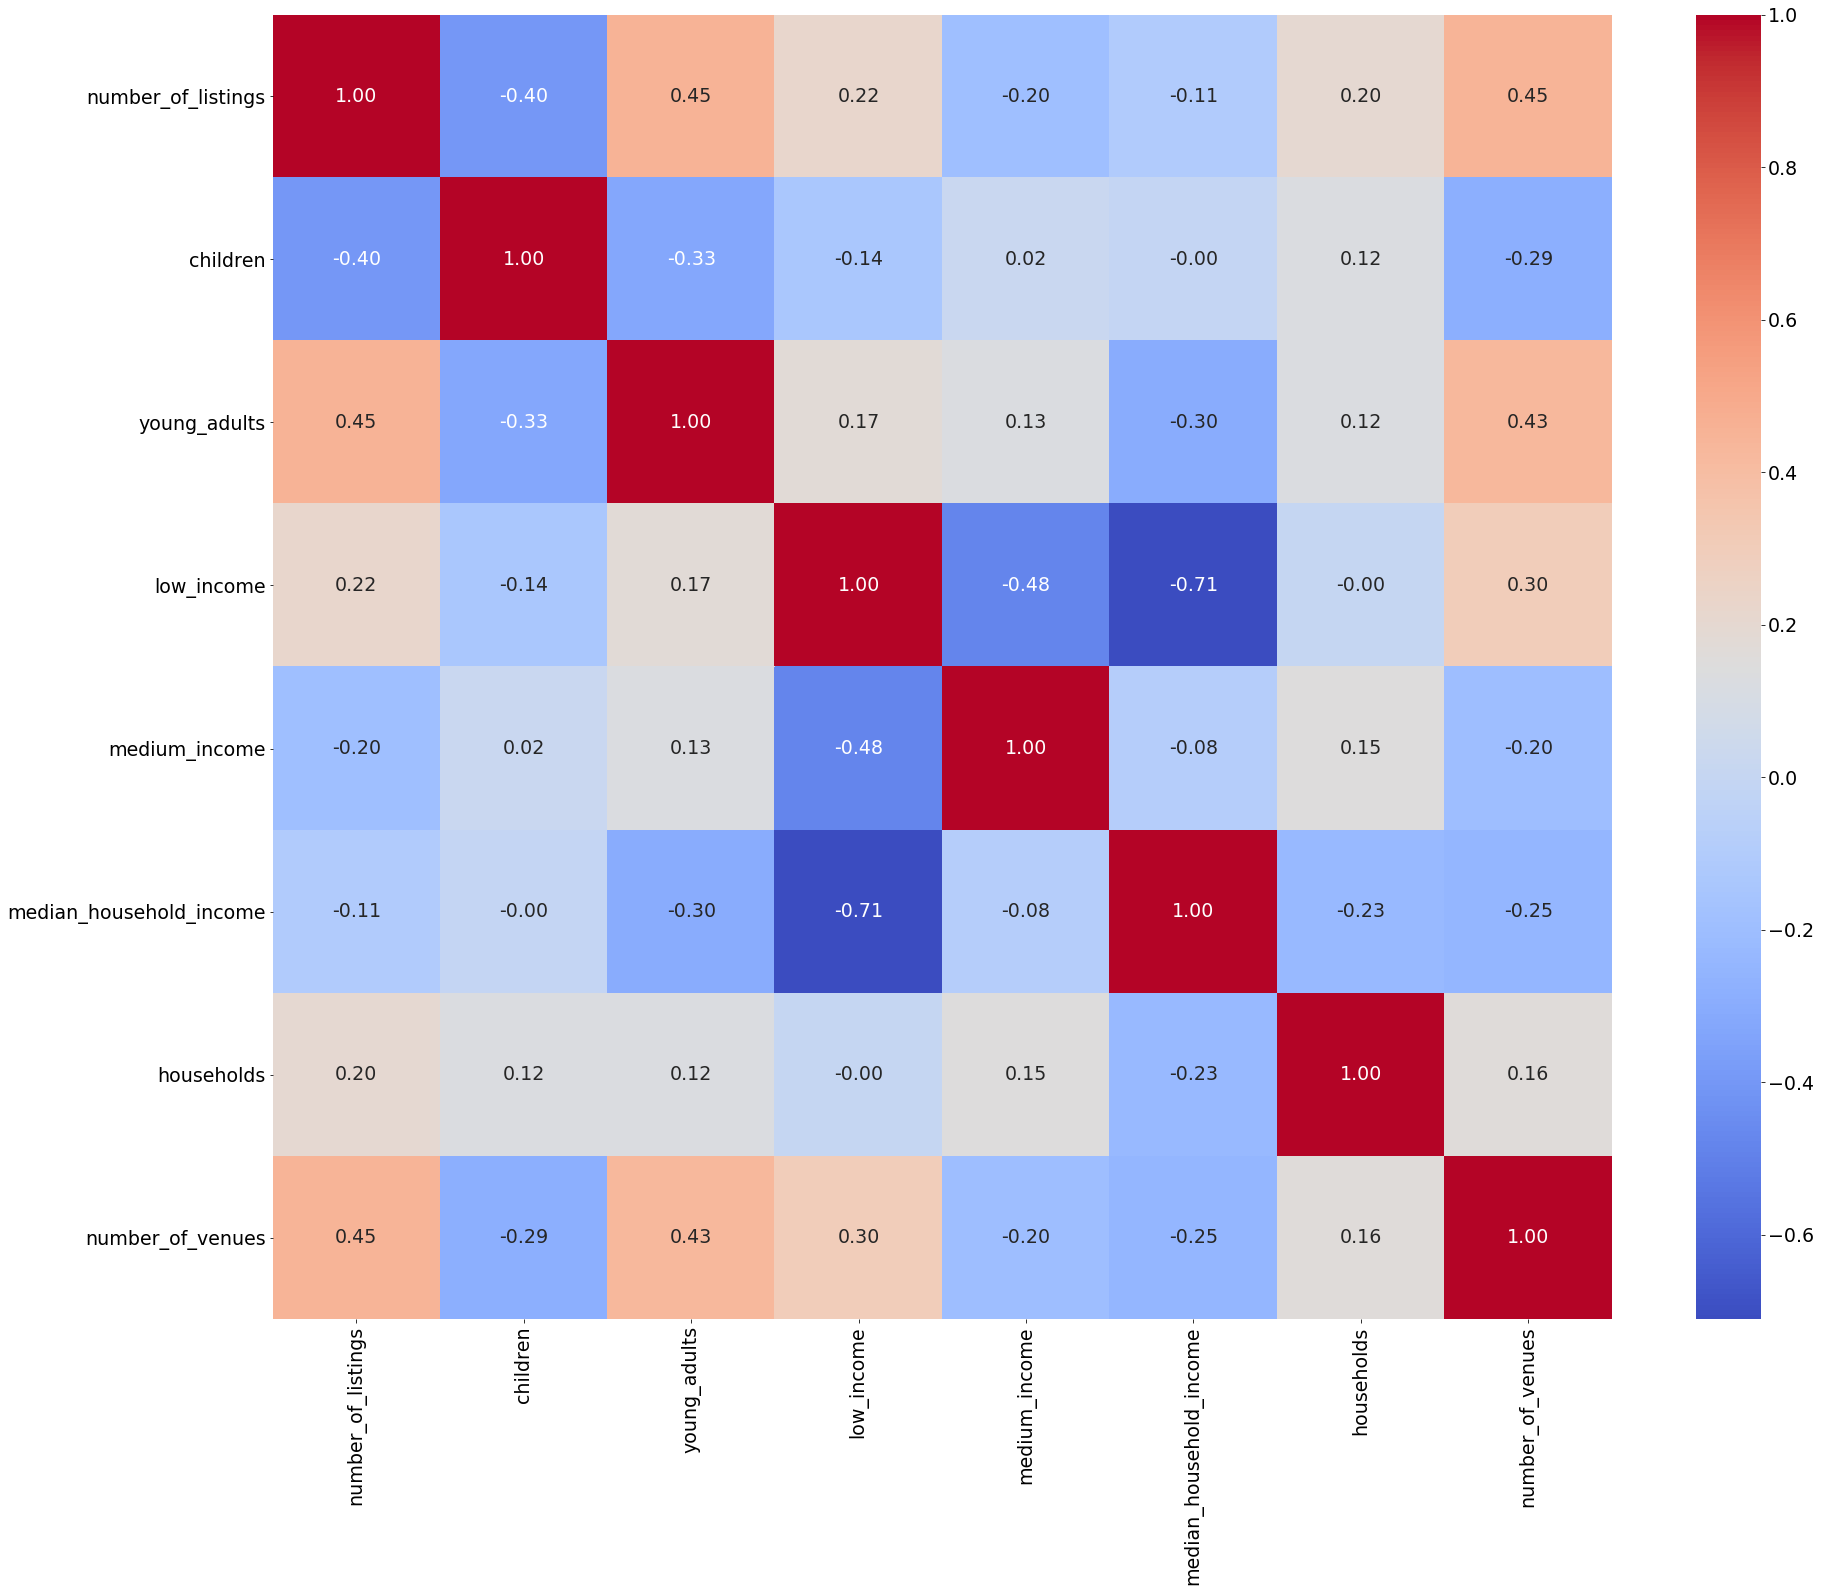

In [73]:
correlation = df2[['number_of_listings', 'children', 'young_adults', 'low_income', 'medium_income', 'median_household_income', 'households', 'number_of_venues']].corr()

plt.figure(figsize = (30, 24))
matplotlib.rcParams.update({'font.size': 19})
sns.heatmap(correlation,annot=True, fmt = ".2f", cmap = "coolwarm")
#plt.yticks(rotation = 45)
#plt.xticks(rotation = 45)
plt.savefig("corrmap_2.pdf")


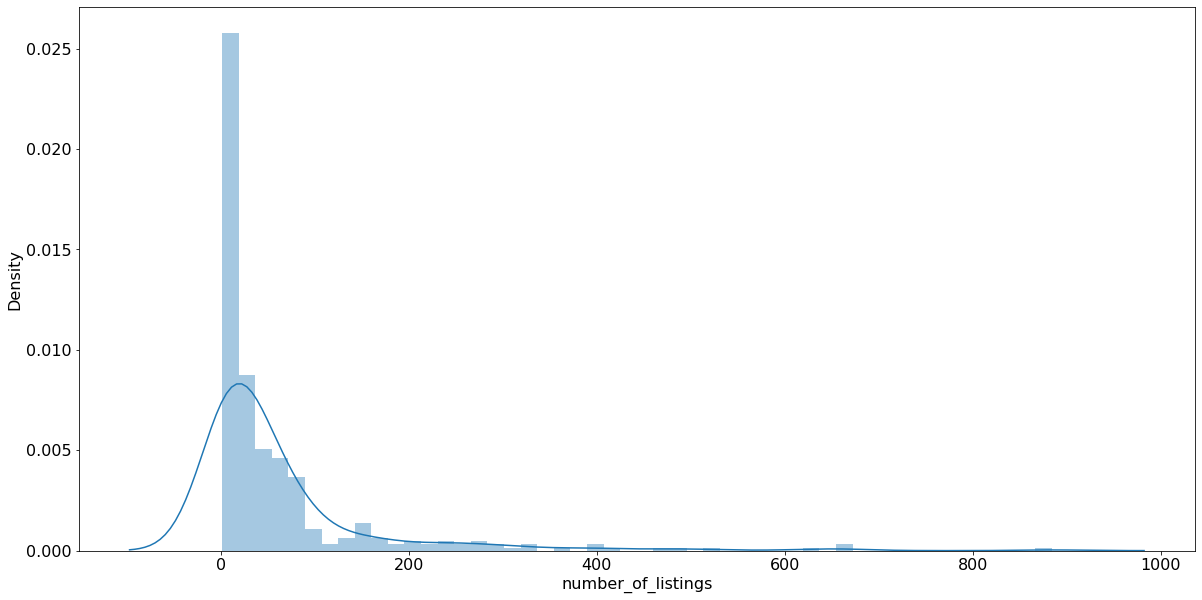

In [27]:
plt.figure(figsize = (20, 10))
sns.distplot(df2['number_of_listings'])

In [28]:
df_low = df2[df2['number_of_listings'] < 100]
#df_medium = df2[(df2['number_of_listings'] > 80) & (df2['number_of_listings'] < 150)]
df_high = df2[df2['number_of_listings'] >= 100]

In [29]:
df_high['state'].value_counts()

CA    31
TX     9
LA     7
TN     4
Name: state, dtype: int64

In [30]:
statistics = pd.DataFrame(index = ['young_adults', 'children', 'low_income', 'medium_income', 'median_household_income', 'households', 'number_of_venues'])

In [31]:
statistics['KS p-val'] = [ks_2samp(df_low['young_adults'], df_high['young_adults'])[1], ks_2samp(df_low['children'], df_high['children'])[1], ks_2samp(df_low['low_income'], df_high['low_income'])[1], ks_2samp(df_low['medium_income'], df_high['medium_income'])[1], ks_2samp(df_low['median_household_income'], df_high['median_household_income'])[1], ks_2samp(df_low['households'], df_high['households'])[1], ks_2samp(df_low['number_of_venues'], df_high['number_of_venues'])[1]]

In [32]:
mean_high = []
mean_low = []
stdev_high = []
stdev_low = []

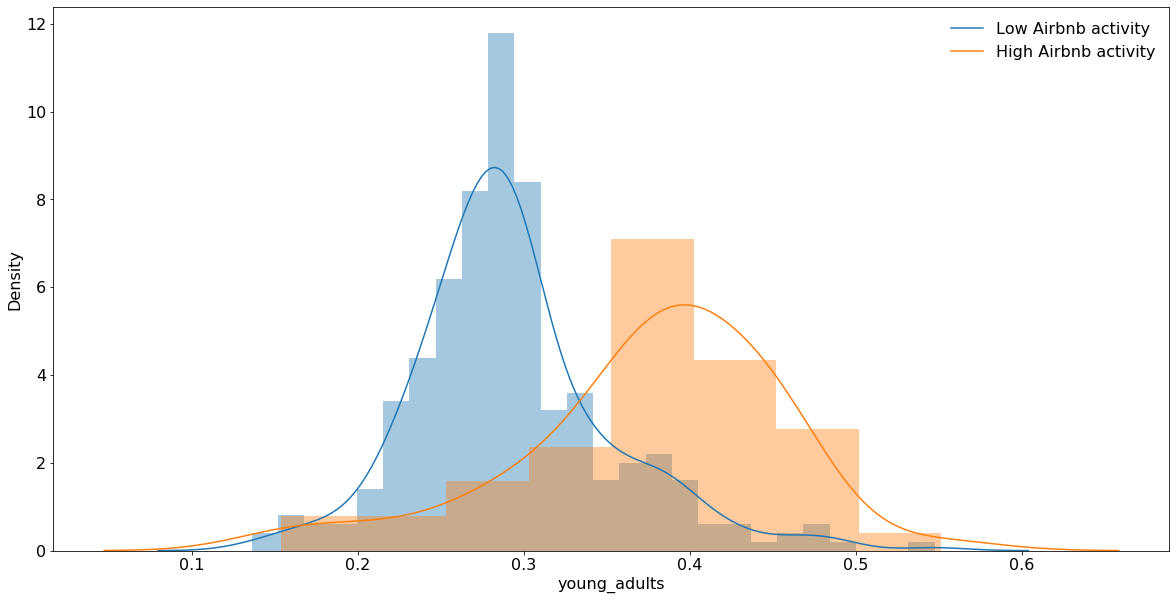

In [33]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['young_adults'])

mean_low.append(df_low['young_adults'].mean())
stdev_low.append(df_low['young_adults'].std())
mean_high.append(df_high['young_adults'].mean())
stdev_high.append(df_high['young_adults'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['young_adults'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

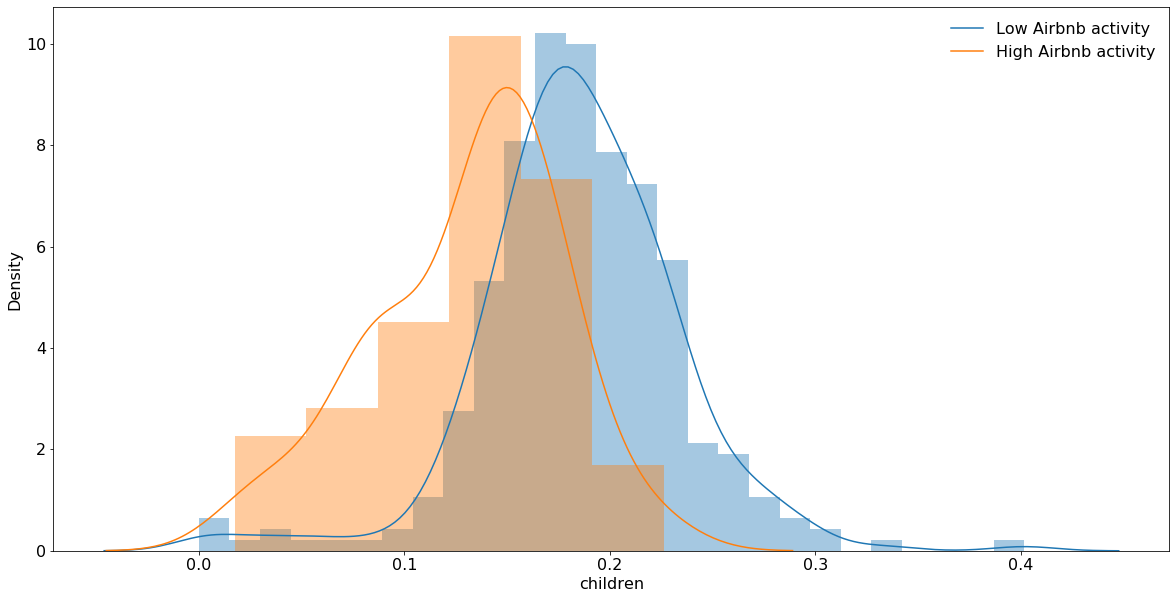

In [34]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['children'])

mean_low.append(df_low['children'].mean())
stdev_low.append(df_low['children'].std())
mean_high.append(df_high['children'].mean())
stdev_high.append(df_high['children'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['children'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

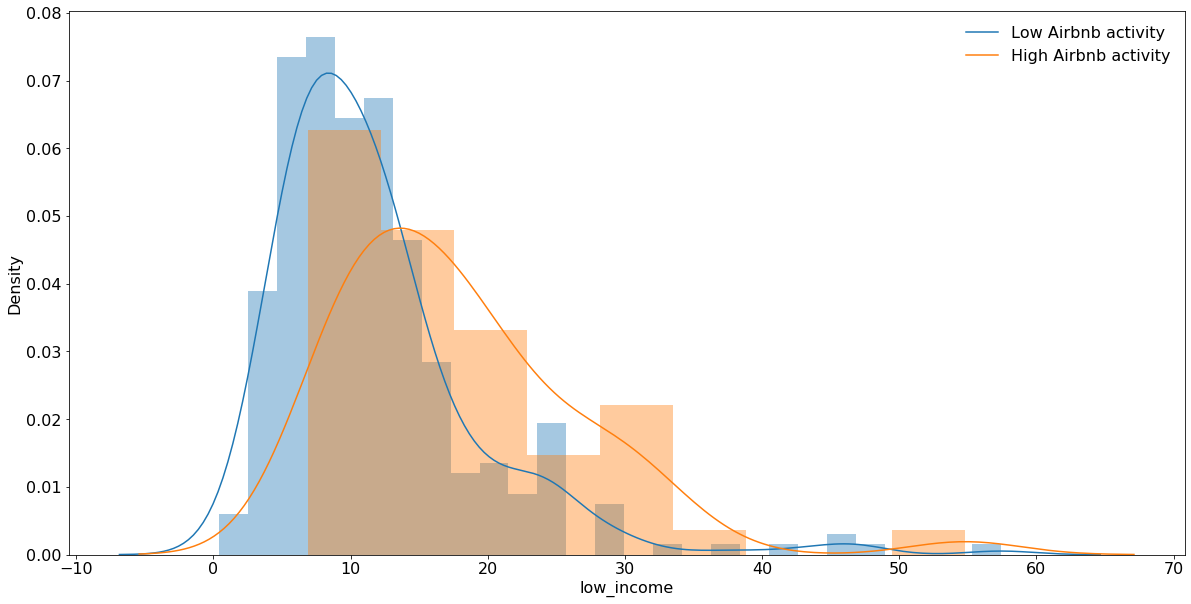

In [35]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['low_income'])

mean_low.append(df_low['low_income'].mean())
stdev_low.append(df_low['low_income'].std())
mean_high.append(df_high['low_income'].mean())
stdev_high.append(df_high['low_income'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['low_income'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

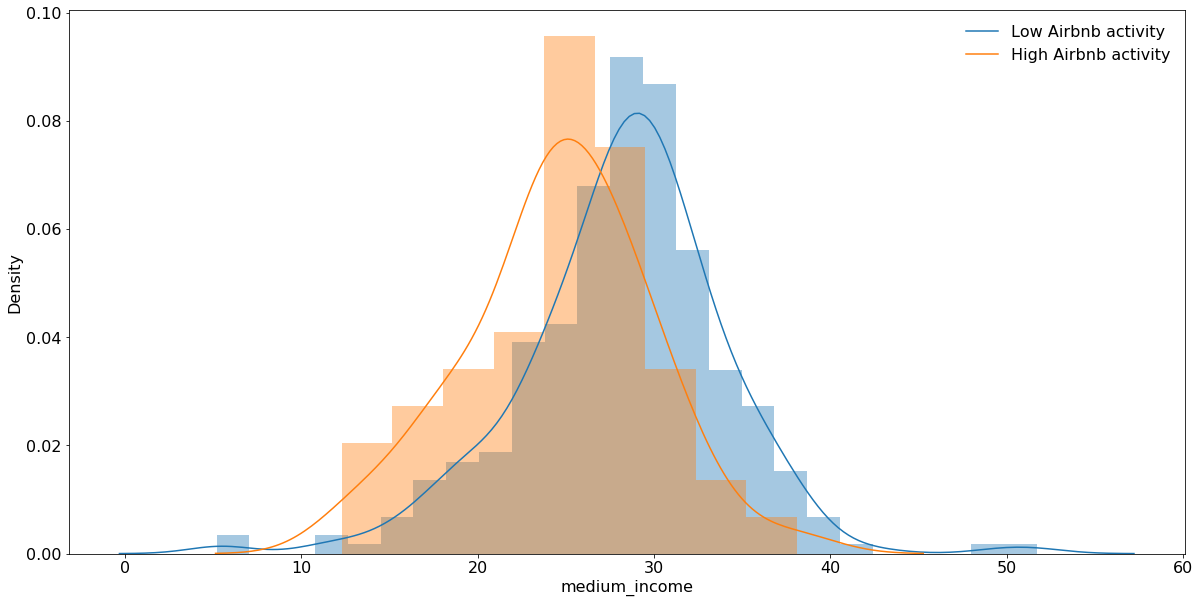

In [36]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['medium_income'])

mean_low.append(df_low['medium_income'].mean())
stdev_low.append(df_low['medium_income'].std())
mean_high.append(df_high['medium_income'].mean())
stdev_high.append(df_high['medium_income'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['medium_income'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

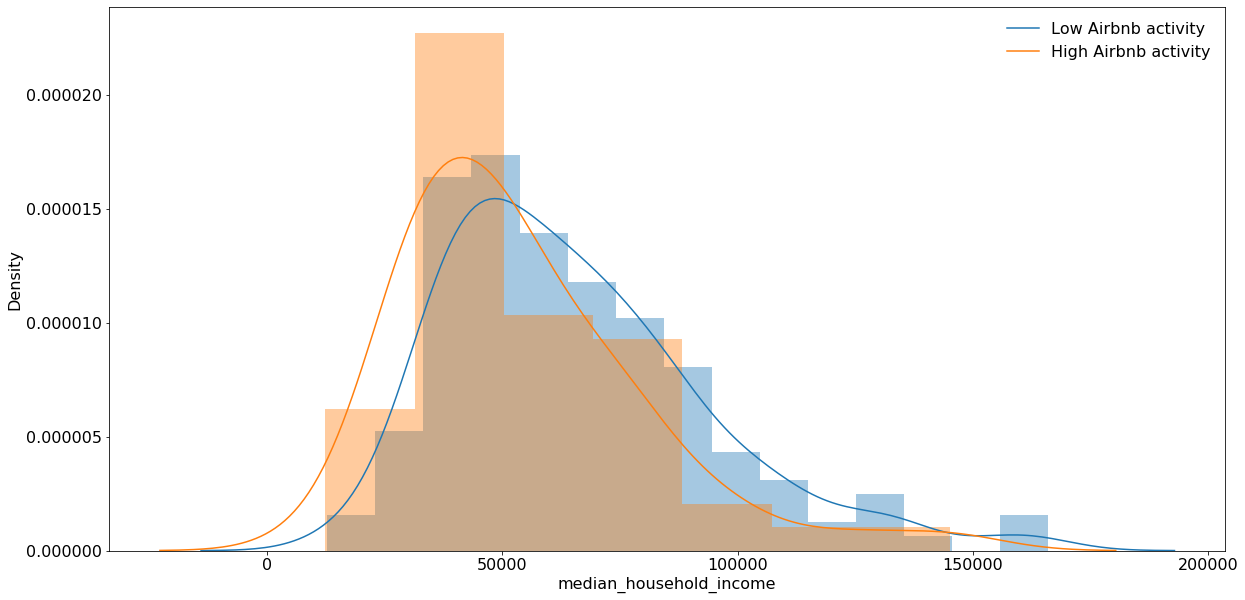

In [37]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['median_household_income'])

mean_low.append(df_low['median_household_income'].mean())
stdev_low.append(df_low['median_household_income'].std())
mean_high.append(df_high['median_household_income'].mean())
stdev_high.append(df_high['median_household_income'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['median_household_income'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

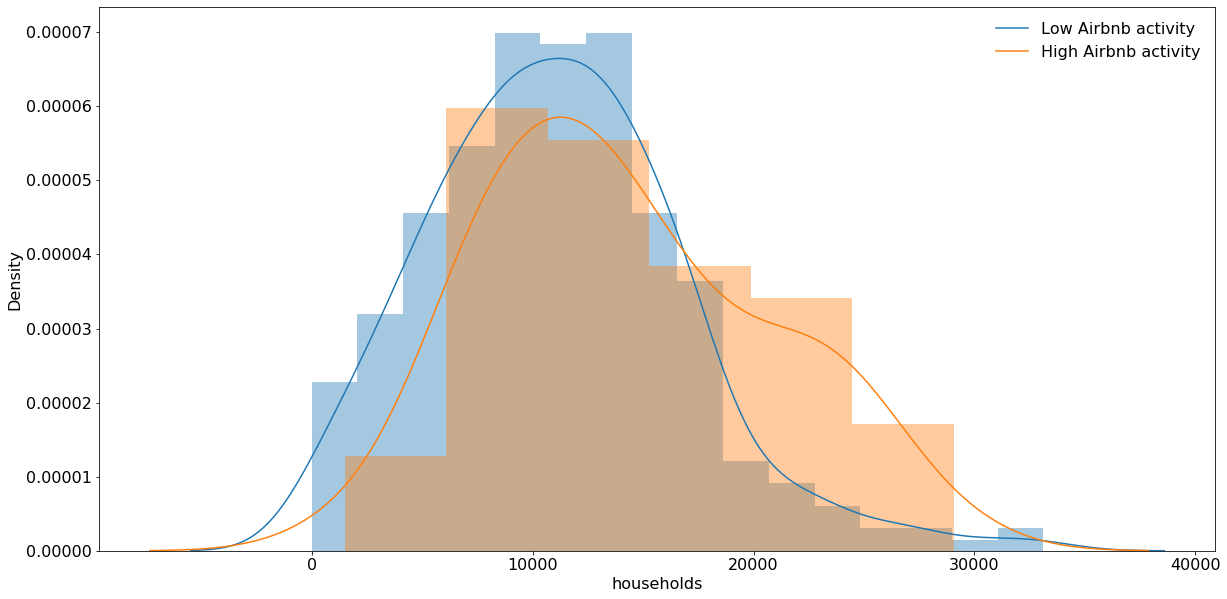

In [38]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['households'])

mean_low.append(df_low['households'].mean())
stdev_low.append(df_low['households'].std())
mean_high.append(df_high['households'].mean())
stdev_high.append(df_high['households'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['households'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

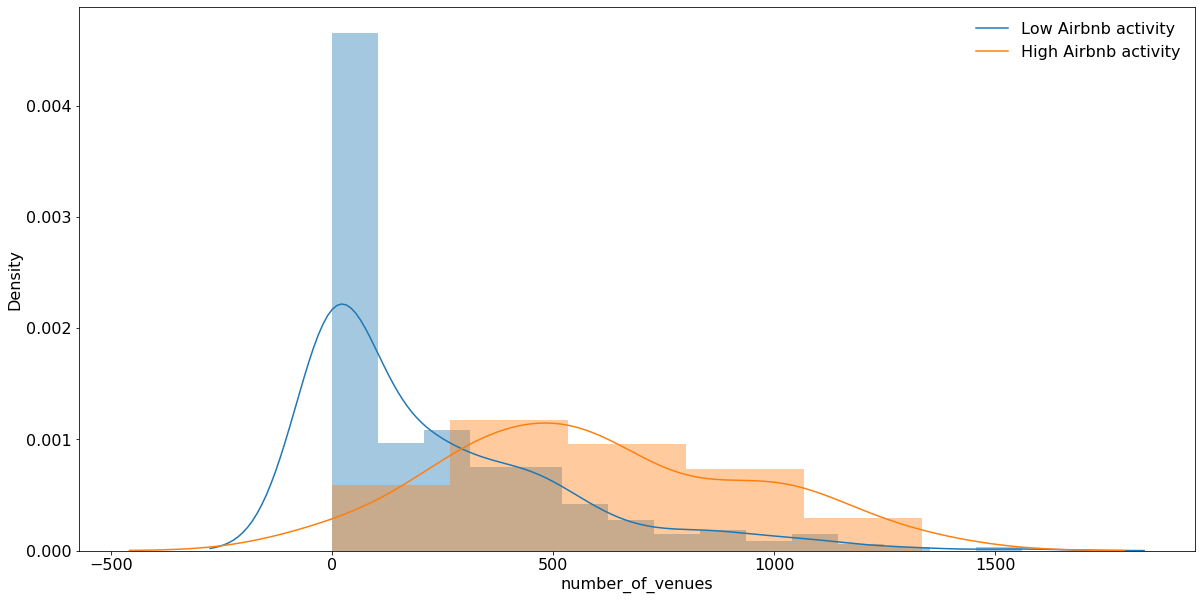

In [39]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['number_of_venues'])

mean_low.append(df_low['number_of_venues'].mean())
stdev_low.append(df_low['number_of_venues'].std())
mean_high.append(df_high['number_of_venues'].mean())
stdev_high.append(df_high['number_of_venues'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['number_of_venues'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

In [40]:
statistics['mean_high'] = mean_high
statistics['mean_low'] = mean_low
statistics['stdev_high'] = stdev_high
statistics['stdev_low'] = stdev_low

In [41]:
statistics

,KS p-val,mean_high,mean_low,stdev_high,stdev_low
young_adults,2.553513e-15,0.376576,0.292809,0.078171,0.059565
children,4.437350e-11,0.130656,0.185385,0.045882,0.048537
low_income,1.519416e-06,17.960784,11.779114,9.006089,7.640228
medium_income,2.814294e-05,24.549020,28.221519,5.240587,5.807886
median_household_income,3.528600e-03,53667.392157,65448.822785,25714.620537,28272.847707
households,2.687231e-02,14228.686275,11082.440252,6452.437349,5778.433009
number_of_venues,1.254552e-14,598.294118,228.034591,334.721813,290.468514


In [42]:
variables = list(statistics.index)
variables

['young_adults',
 'children',
 'low_income',
 'medium_income',
 'median_household_income',
 'households',
 'number_of_venues']

<Figure size 1440x1728 with 0 Axes>

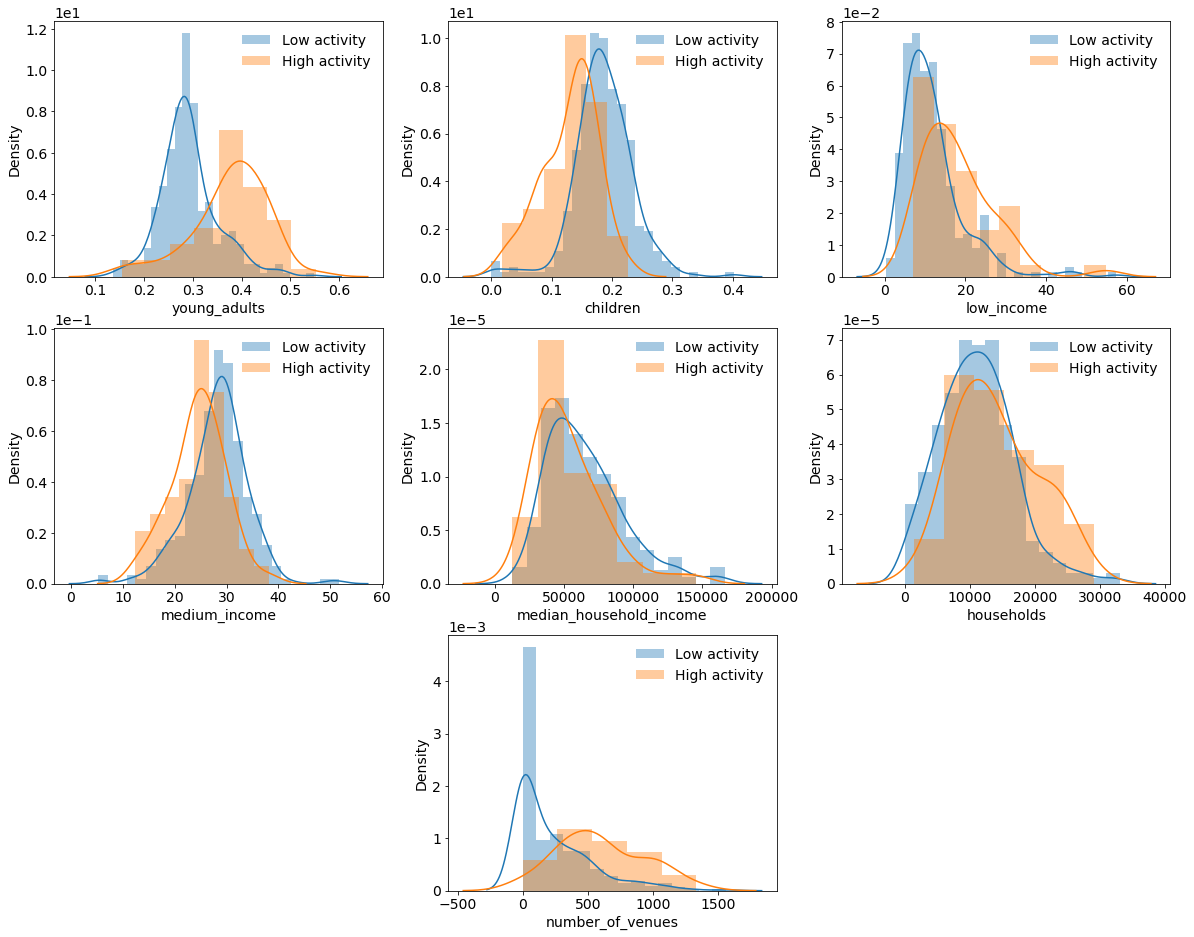

In [43]:
plt.figure(figsize = (20, 24))
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(3, 3, figsize  = (20, 16))

for i in range(len(variables) - 1):
    var = variables[i]
    sns.distplot(df_low[var], label = 'Low activity', ax = ax[i//3, i%3])
    sns.distplot(df_high[var], label = 'High activity', ax = ax[i//3, i%3])
    
    handles, labels = ax[i//3, i%3].get_legend_handles_labels()
    order = [0,1]
    ax[i//3, i%3].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 1, frameon = False)
    ax[i//3, i%3].ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))
    #ax[i//3, i%3].set_xlabel("")

var = 'number_of_venues'
sns.distplot(df_low[var], label = 'Low activity', ax = ax[2, 1])
sns.distplot(df_high[var], label = 'High activity', ax = ax[2, 1])
    
handles, labels = ax[2, 1].get_legend_handles_labels()
order = [0,1]
ax[2,1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 1, frameon = False)
ax[2, 1].ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))
#ax[2, 1].set_xlabel("")

fig.delaxes(ax[2,0])
fig.delaxes(ax[2,2])

plt.savefig("./distributions_2.pdf")
    
    

In [44]:
statistics

,KS p-val,mean_high,mean_low,stdev_high,stdev_low
young_adults,2.553513e-15,0.376576,0.292809,0.078171,0.059565
children,4.437350e-11,0.130656,0.185385,0.045882,0.048537
low_income,1.519416e-06,17.960784,11.779114,9.006089,7.640228
medium_income,2.814294e-05,24.549020,28.221519,5.240587,5.807886
median_household_income,3.528600e-03,53667.392157,65448.822785,25714.620537,28272.847707
households,2.687231e-02,14228.686275,11082.440252,6452.437349,5778.433009
number_of_venues,1.254552e-14,598.294118,228.034591,334.721813,290.468514


In [45]:
print(statistics.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &      KS p-val &     mean\_high &      mean\_low &    stdev\_high &     stdev\_low \\
\midrule
young\_adults            &  2.553513e-15 &      0.376576 &      0.292809 &      0.078171 &      0.059565 \\
children                &  4.437350e-11 &      0.130656 &      0.185385 &      0.045882 &      0.048537 \\
low\_income              &  1.519416e-06 &     17.960784 &     11.779114 &      9.006089 &      7.640228 \\
medium\_income           &  2.814294e-05 &     24.549020 &     28.221519 &      5.240587 &      5.807886 \\
median\_household\_income &  3.528600e-03 &  53667.392157 &  65448.822785 &  25714.620537 &  28272.847707 \\
households              &  2.687231e-02 &  14228.686275 &  11082.440252 &   6452.437349 &   5778.433009 \\
number\_of\_venues        &  1.254552e-14 &    598.294118 &    228.034591 &    334.721813 &    290.468514 \\
\bottomrule
\end{tabular}



# Part 6: activity within the most active zipcodes

df_high

avg_occ_by_zip = pd.read_csv("./avg_occ_rate_by_zipcode.csv")

avg_occ_by_zip['average_occupancy'] = avg_occ_by_zip['occupied_per']

df_high = df_high.merge(avg_occ_by_zip, how = 'left', on = 'zipcode')

correlation = df_high[['average_occupancy', 'number_of_listings', 'children', 'young_adults', 'low_income', 'medium_income', 'median_household_income', 'households', 'number_of_venues']].corr()

plt.figure(figsize = (20, 16))

sns.heatmap(correlation,annot=True, fmt = ".2f", cmap = "coolwarm")
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
#plt.savefig("corrmap2.pdf")

df_high

plt.figure(figsize = (20, 10))

for state in df_high.state.unique():
    print("State " + state)
    print(len(df_high[df_high['state'] == state]))
    print(df_high[df_high['state'] == state]['average_occupancy'].mean())
    sns.distplot(df_high[df_high['state'] == state]['average_occupancy'])

Trying simple linear regression 

In [46]:
from sklearn.linear_model import LinearRegression
import copy

lr = LinearRegression()

train = copy.deepcopy(df2[['children', 'young_adults', 'low_income', 'medium_income', 'median_household_income', 'number_of_listings', 'number_of_venues', 'households']])

train = train.dropna()

X = train[['children', 'young_adults', 'low_income', 'medium_income', 'number_of_venues', 'households', 'median_household_income']]
y = train['number_of_listings']

lr.fit(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
lr.score(X, y)

# R^2 score of linear regression
# generally speaking, 1 is perfect, 0 is if we predict constant mean value

0.4065454620463991

In [48]:
lr.coef_

array([-5.43862803e+02,  4.80314154e+02,  8.48805246e-01, -3.35839249e+00,
        5.88059557e-02,  3.86140386e-03,  4.01574317e-04])

In [49]:
import statsmodels.api as sm
from scipy import stats

In [50]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     number_of_listings   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     35.13
Date:                Sun, 18 Jul 2021   Prob (F-statistic):           3.01e-37
Time:                        16:38:01   Log-Likelihood:                -2139.7
No. Observations:                 367   AIC:                             4295.
Df Residuals:                     359   BIC:                             4327.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [51]:
df2['state'].value_counts()

CA    270
TX     42
TN     29
LA     20
NC      8
Name: state, dtype: int64

In [52]:
listings['clean_zip'] = listings['zipcode'].apply(lambda z: clean(z))
l_mod = copy.deepcopy(listings)

In [53]:
l_mod = l_mod.dropna(subset = ['clean_zip'])

In [54]:
dch = {}
for el in df2['zipcode'].unique():
    dch[el] = df2[df2['zipcode'] == el]['children'].values[0]

dya = {}
for el in df2['zipcode'].unique():
    dya[el] = df2[df2['zipcode'] == el]['young_adults'].values[0]
    
dli = {}
for el in df2['zipcode'].unique():
    dli[el] = df2[df2['zipcode'] == el]['low_income'].values[0]

dmi = {}
for el in df2['zipcode'].unique():
    dmi[el] = df2[df2['zipcode'] == el]['medium_income'].values[0]

In [56]:
l_mod['children'] = l_mod['clean_zip'].apply(lambda z: dch[z] if z in dch.keys() else np.nan)
l_mod['young_adults'] = l_mod['clean_zip'].apply(lambda z: dya[z] if z in dya.keys() else np.nan)

l_mod['low_income'] = l_mod['clean_zip'].apply(lambda z: dli[z] if z in dli.keys() else np.nan)
l_mod['medium_income'] = l_mod['clean_zip'].apply(lambda z: dmi[z] if z in dmi.keys() else np.nan)


In [57]:
l_mod.columns

Index(['accommodates', 'amenities', 'availability_30', 'bathrooms', 'bed_type',
       'bedrooms', 'beds', 'cancellation_policy', 'city', 'has_availability',
       'host_id', 'id', 'instant_bookable', 'latitude', 'longitude',
       'metropolitan', 'name', 'price', 'property_type',
       'review_scores_checkin', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_rating', 'review_scores_value', 'room_type', 'state',
       'weekly_price', 'zipcode', 'overall_activity', 'multi', 'clean_zip',
       'children', 'young_adults', 'low_income', 'medium_income'],
      dtype='object')

In [58]:
dfya = l_mod[['id', 'children', 'young_adults', 'low_income', 'medium_income']]
dfya

,id,children,young_adults,low_income,medium_income
1,2746729,0.190200,0.340500,16.8,27.0
3,12286328,0.190200,0.340500,16.8,27.0
4,156926,0.190200,0.340500,16.8,27.0
5,3767793,0.190200,0.340500,16.8,27.0
15,3645277,0.190200,0.340500,16.8,27.0
...,...,...,...,...,...
50306,15860751,0.177491,0.244908,7.0,24.4
50307,1312336,0.161562,0.290103,8.9,29.5
50309,17302014,0.177491,0.244908,7.0,24.4
50312,18477878,0.266360,0.281628,13.2,30.3


In [59]:
dfya.to_csv("./df_listings_demographics.csv")

In [100]:
listings['clean_zip'].unique()

array([2.88060e+04, 2.88010e+04, 2.88030e+04, 2.88050e+04, 2.88040e+04,
       2.87870e+04,         nan, 2.87150e+04, 2.87040e+04, 2.87320e+04,
       2.87590e+04, 7.87560e+04, 7.87570e+04, 7.87510e+04, 7.87310e+04,
       7.87050e+04, 7.87470e+04, 7.87220e+04, 7.87520e+04, 7.87390e+04,
       7.87480e+04, 7.87370e+04, 7.87490e+04, 7.87540e+04, 7.87530e+04,
       7.87320e+04, 7.87260e+04, 7.87300e+04, 7.87360e+04, 7.86200e+04,
       7.87120e+04, 7.87340e+04, 7.87380e+04, 7.87250e+04, 7.87240e+04,
       7.87580e+04, 7.87280e+04, 7.87270e+04, 7.87440e+04, 7.87450e+04,
       7.87740e+04, 7.86440e+04, 7.87350e+04, 7.87040e+04, 7.87410e+04,
       7.87460e+04, 7.87190e+04, 7.86170e+04, 7.87420e+04, 7.87020e+04,
       7.87030e+04, 7.87010e+04, 7.87170e+04, 7.87500e+04, 7.87230e+04,
       7.87590e+04, 7.86520e+04, 7.87290e+04, 7.87210e+04, 7.82180e+04,
       7.87330e+04, 9.72020e+04, 3.72090e+04, 3.72180e+04, 3.70150e+04,
       3.71890e+04, 3.70800e+04, 3.72060e+04, 3.72080e+04, 3.721

In [60]:
listings

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,has_availability,...,review_scores_location,review_scores_rating,review_scores_value,room_type,state,weekly_price,zipcode,overall_activity,multi,clean_zip
1,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",17,1.0,Real Bed,1.0,2.0,strict,Asheville,NaN,...,9.0,96.0,9.0,Entire home/apt,NC,NaN,28806.0,68.0,1,28806.0
3,6.0,"{Internet,""Wireless Internet"",""Air Conditionin...",28,2.5,Real Bed,1.0,6.0,moderate,Asheville,NaN,...,NaN,NaN,NaN,Shared room,NC,NaN,28806.0,168.0,1,28806.0
4,6.0,"{Internet,""Wireless Internet"",""Free Parking on...",25,2.5,Real Bed,1.0,6.0,moderate,Asheville,NaN,...,9.0,93.0,10.0,Shared room,NC,NaN,28806.0,150.0,1,28806.0
5,10.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",17,2.5,Real Bed,4.0,5.0,strict,Asheville,NaN,...,8.0,78.0,8.0,Entire home/apt,NC,"$1,550.00",28806.0,170.0,1,28806.0
15,4.0,"{TV,Internet,""Wireless Internet"",""Air Conditio...",18,1.0,Real Bed,1.0,2.0,moderate,Asheville,NaN,...,9.0,93.0,9.0,Private room,NC,NaN,28806.0,72.0,1,28806.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50306,10.0,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",16,2.0,Real Bed,3.0,4.0,strict,los angeles,NaN,...,10.0,70.0,8.0,Entire home/apt,CA,NaN,91364,160.0,1,91364.0
50307,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5,1.0,Real Bed,1.0,3.0,strict,woodland hills,NaN,...,9.0,91.0,9.0,Entire home/apt,CA,NaN,91367,20.0,1,91367.0
50309,2.0,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",0,1.0,Real Bed,1.0,1.0,flexible,los angeles,NaN,...,NaN,NaN,NaN,Private room,CA,NaN,91364,0.0,1,91364.0
50312,4.0,"{TV,""Air conditioning"",Kitchen,""Free parking o...",13,0.5,Real Bed,1.0,2.0,strict,los angeles,NaN,...,NaN,NaN,NaN,Entire home/apt,CA,NaN,90744,52.0,1,90744.0


In [61]:
dfya

,id,children,young_adults,low_income,medium_income
1,2746729,0.190200,0.340500,16.8,27.0
3,12286328,0.190200,0.340500,16.8,27.0
4,156926,0.190200,0.340500,16.8,27.0
5,3767793,0.190200,0.340500,16.8,27.0
15,3645277,0.190200,0.340500,16.8,27.0
...,...,...,...,...,...
50306,15860751,0.177491,0.244908,7.0,24.4
50307,1312336,0.161562,0.290103,8.9,29.5
50309,17302014,0.177491,0.244908,7.0,24.4
50312,18477878,0.266360,0.281628,13.2,30.3


First 2 coeff are of the opposite sign - that is fine, since the corresponding variables are negatively correlated. Mostly learns information from proportion of young adults and children.

In [29]:
!jupyter nbconvert --to html Notebook1.ipynb

[NbConvertApp] Converting notebook Notebook1.ipynb to html
[NbConvertApp] Writing 885420 bytes to Notebook1.html
